## Import statements

In [1]:
from typing import DefaultDict
import freud
import numpy as np
import gsd.hoomd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats
import argparse
import pathlib
import glob
import os
import dotenv

import warnings

from itertools import product

from schmeud.utils import parse_flag_from_string

mpl.rcParams.update({'font.size': 15})

%config InlineBackend.figure_format = 'retina'

In [2]:
dotenv.load_dotenv()
data_dir = pathlib.Path(os.environ["CAKE_DATA_DIR"])
ifiles = glob.glob(str(data_dir / "monk/pre_softness_fire/run*/*/*.gsd"))
ifiles[0]

'/home/igraham/Data/monk/pre_softness_fire/run1/pair-KA_LJ_phi-1.2/temp-0.45_seed-0.gsd'

## Data calculation

In [3]:
def calculate_msd(file, skip=None):

    traj = gsd.hoomd.open(file, mode='rb')
    snap = traj[0]
    gsd_box = snap.configuration.box

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        box = freud.box.Box(*gsd_box)

    msd = freud.msd.MSD(mode='window')

    # properly wrap trajectory
    for enum_i, idx in enumerate(range(0,len(traj),skip)):
        if enum_i == 0:
            last_pos = traj[idx].particles.position
            pos = []
            pos.append(last_pos)
        else:
            snap = traj[idx]
            next_pos = snap.particles.position
            dx = box.wrap(next_pos - last_pos)

            pos.append(pos[-1] + dx)
            last_pos = next_pos

    pos = np.array(pos)
    computed_msd = msd.compute(pos).msd

    return computed_msd

In [4]:
N = 10_000
skip = 100
min_temp = 0.45
max_temp = 1.0

time = np.linspace(0, N, N//skip)

msds = DefaultDict(list)
for file in ifiles:
    system_tag = file.split("/")[-2]
    temp = float(parse_flag_from_string(file, "temp-"))
    msds[system_tag].append((temp, calculate_msd(file, skip=skip)))

## Plotting

In [24]:
def plot_msd(time, msds, alpha=None, key=None):
    cmap = cm.jet
    norm = colors.Normalize(vmin=min_temp, vmax=max_temp)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    symbols = ('o', 'x', 'D', '.')
    for idx, item in enumerate(msds.items()):
        
        pair, temp_msds = item
        if key is not None and pair != key:
            continue
        for temp, msd in temp_msds:
            plt.plot(time[1:], msd[1:], symbols[idx], label=pair, color=cmap(norm(temp)), alpha=alpha)
            pair = None

    plt.yscale('log')
    plt.xscale('log')
    # plt.legend()
    plt.ylabel(r"$\mathcal{MSD}$")
    plt.xlabel(r"$t \; [\tau_{A}]$")
    plt.colorbar(sm, label=r"$k_b T$")

def plot_dr2_dt(time, msds, alpha=None, key=None):
    cmap = cm.jet
    norm = colors.Normalize(vmin=min_temp, vmax=max_temp)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    symbols = ('o', 'x', 'D', '.')
    short_time = time[:-1]
    for idx, item in enumerate(msds.items()):
        
        pair, temp_msds = item
        if key is not None and pair != key:
            continue
        for temp, msd in temp_msds:
            plt.plot(short_time, np.diff(msd), symbols[idx], label=pair, color=cmap(norm(temp)), alpha=alpha)
            pair = None

    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r"$\frac{\partial r^2}{\partial t}$")
    plt.xlabel(r"$t \; [\tau_{A}]$")
    # plt.legend()
    plt.colorbar(sm, label=r"$k_b T$")

def plot_D_vs_invT(time, msds, slc=slice(20)):
    cmap = cm.Set1
    norm = colors.Normalize(vmin=0, vmax=4)
    symbols = ('o', 'x', 'D', '.')
    for idx, item in enumerate(msds.items()):
        pair, temp_msds = item
        for temp, msd in temp_msds:
            result = scipy.stats.linregress(x=time[slc], y=msd[slc])
            plt.plot(1/temp, result.slope, symbols[idx], label=pair, color="k")
            pair = None

    plt.yscale('log')
    plt.ylabel(r"$D$")
    plt.xlabel(r"$1/T$")
    # plt.legend()

def plot_alpha_vs_invT(time, msds, slc=slice(1,20)):
    cmap = cm.Set1
    norm = colors.Normalize(vmin=0, vmax=4)
    symbols = ('o', 'x', 'D', '.')
    for idx, item in enumerate(msds.items()):
        pair, temp_msds = item
        for temp, msd in temp_msds:
            logx = np.log(time[slc])
            logy = np.log(msd[slc])
            coeffs = np.polyfit(logx,logy,deg=1)
            plt.plot(1/temp, coeffs[0], symbols[idx], label=pair, color="k")
            pair = None

    # plt.yscale('log')
    plt.ylabel(r"$\alpha$")
    plt.xlabel(r"$1/T$")
    # plt.legend()



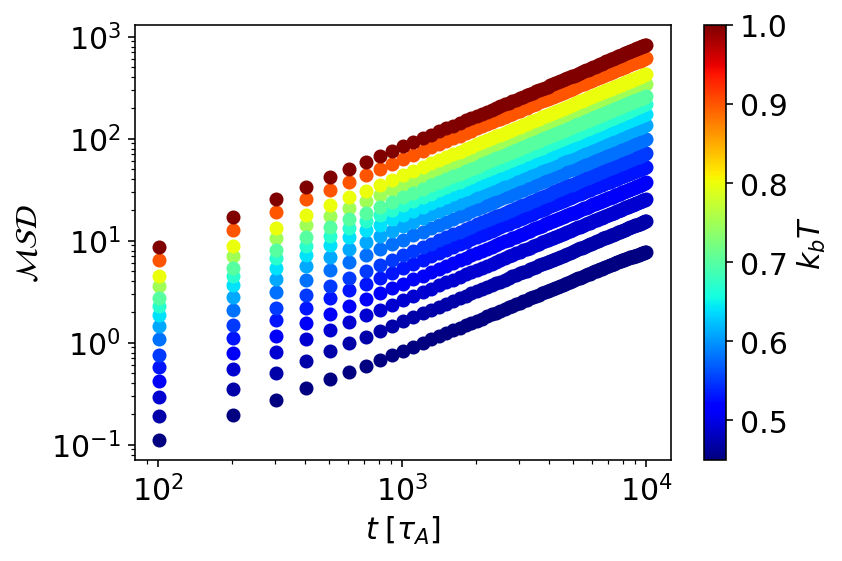

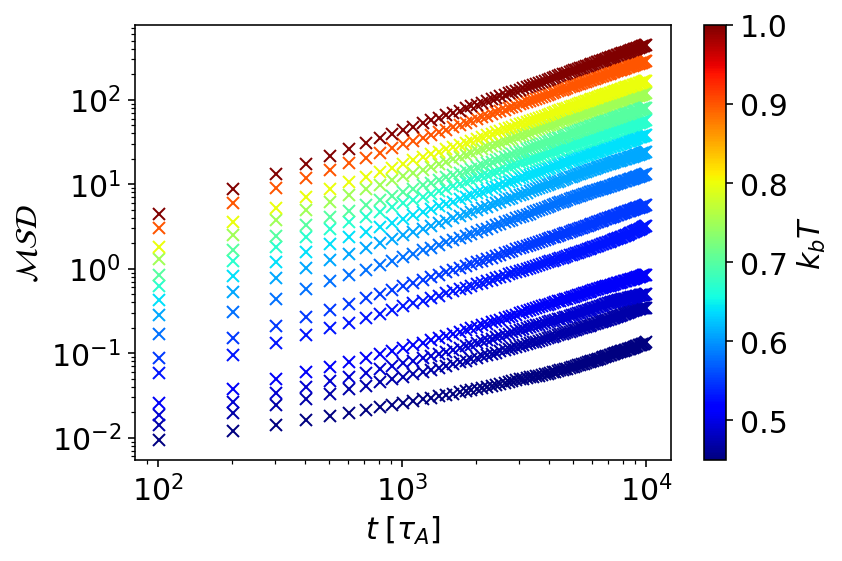

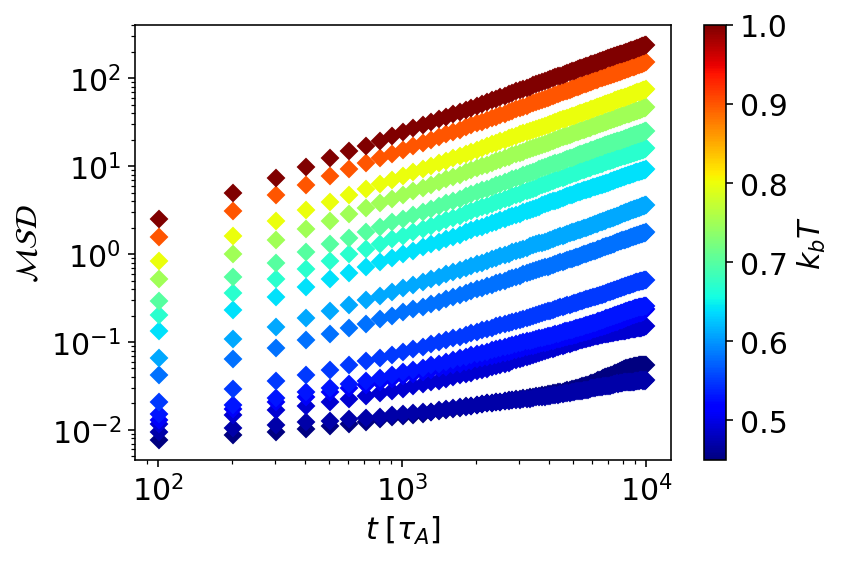

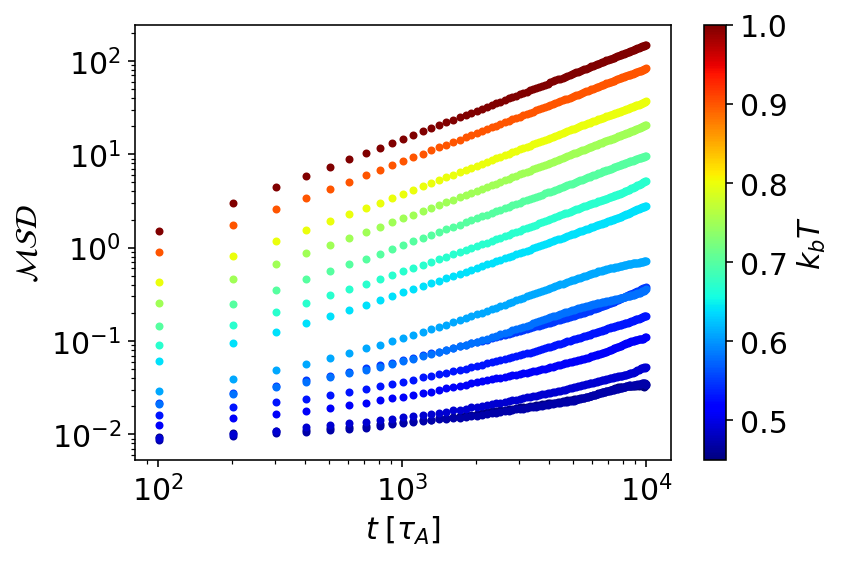

In [25]:
for key in msds.keys():
    plt.figure()
    plot_msd(time, msds, key=key)

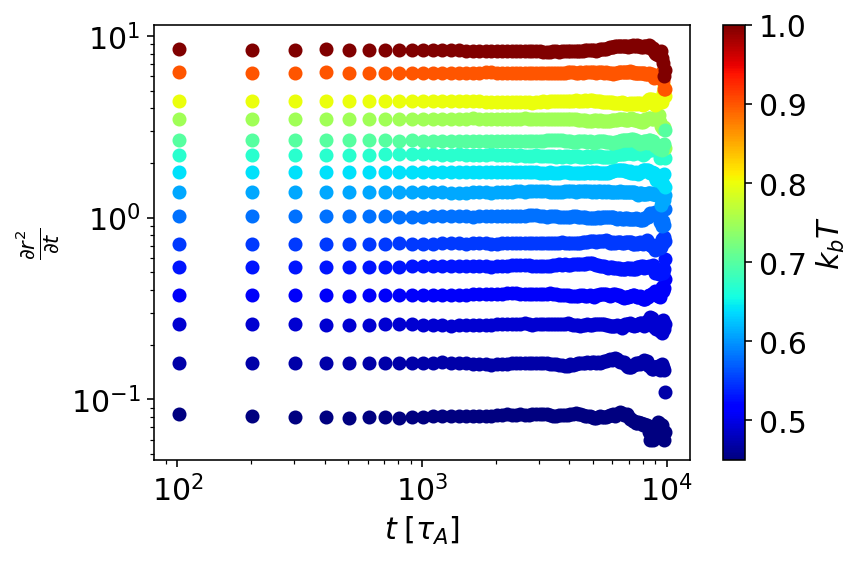

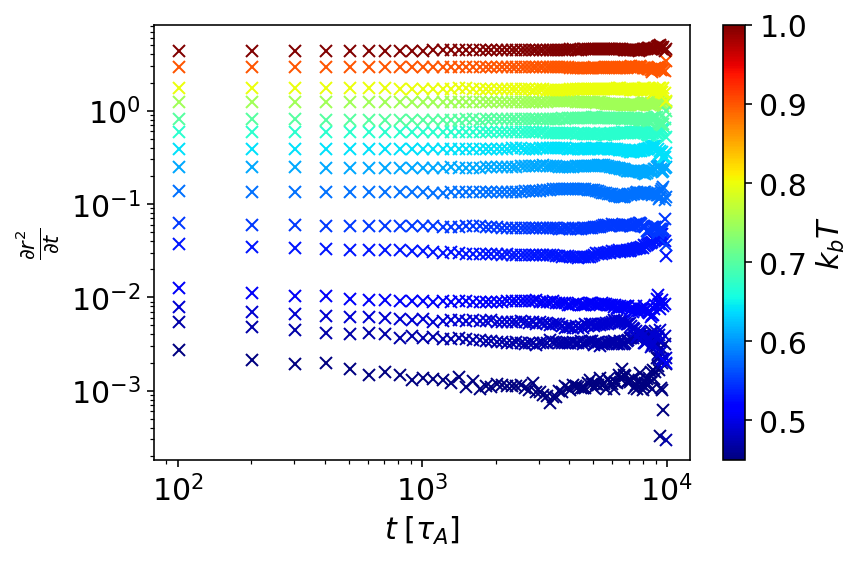

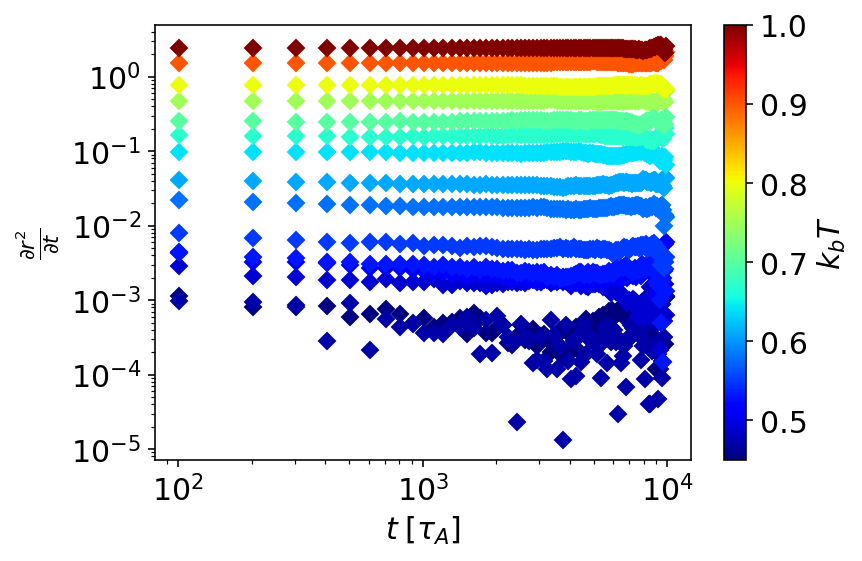

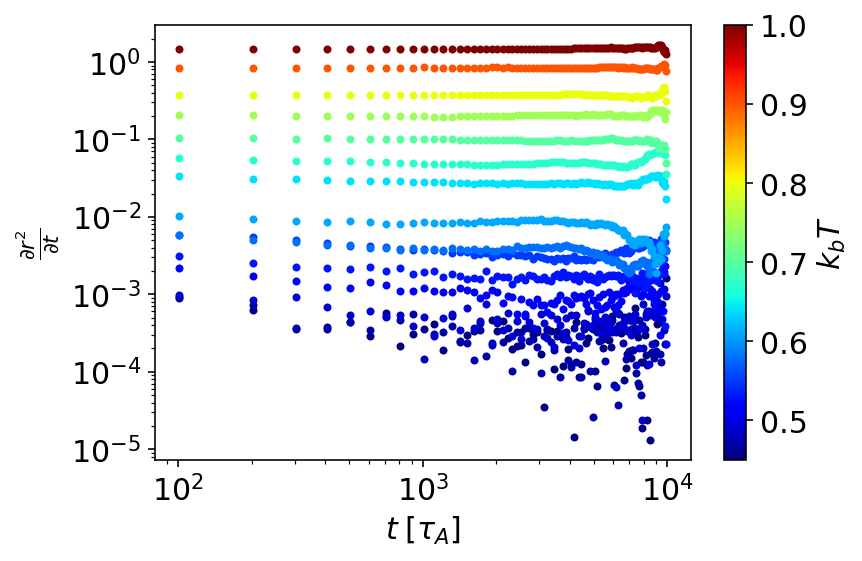

In [26]:
for key in msds.keys():
    plt.figure()
    plot_dr2_dt(time, msds, key=key)

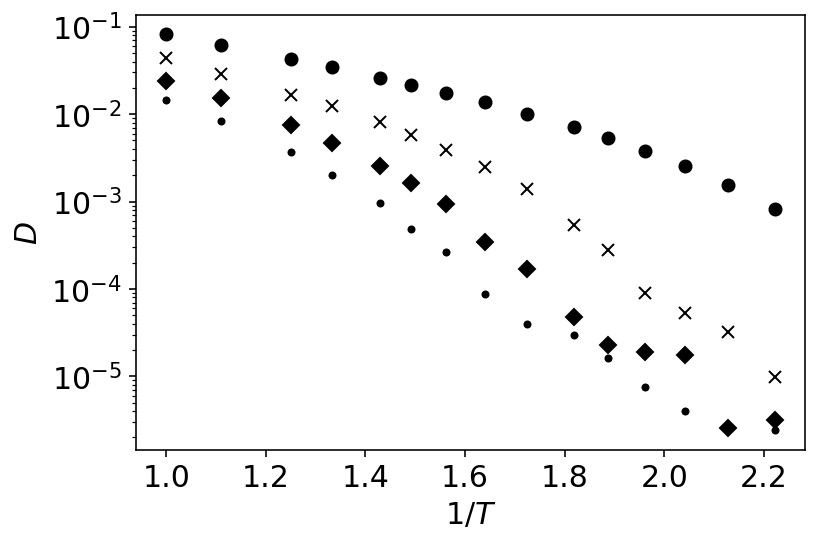

In [27]:
# plot_D_vs_invT(time, msds)
plot_D_vs_invT(time, msds, slc=slice(20,40))

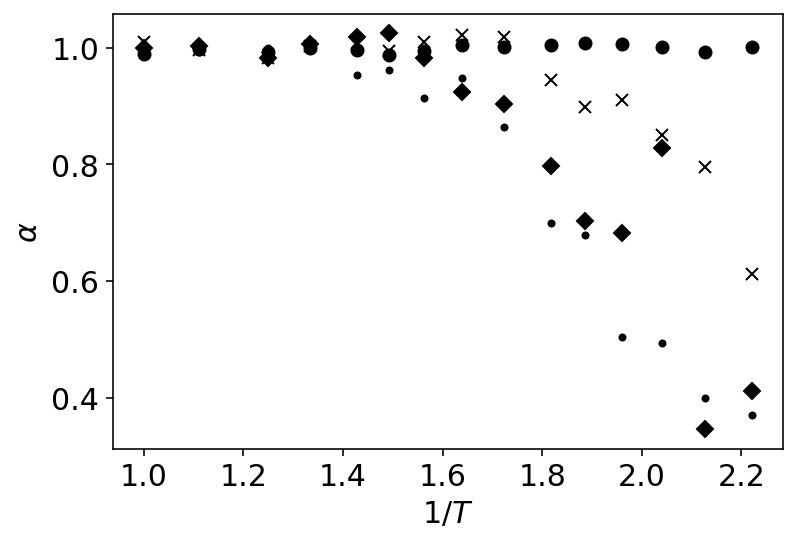

In [28]:
# plot_alpha_vs_invT(time, msds)
plot_alpha_vs_invT(time, msds, slc=slice(20, 40))

In [38]:
import itertools

def plot_D_vs_invT_cutoffs(time, msds, cutoffs, slc=slice(20), colorz=itertools.cycle("k")):
    cmap = cm.Set1
    norm = colors.Normalize(vmin=0, vmax=4)
    symbols = ('o', 'x', 'D', '.')
    for idx, (item, end, color) in enumerate(zip(msds.items(), cutoffs, colorz)):
        pair, temp_msds = item
        for temp, msd in sorted(temp_msds)[end:]:
            result = scipy.stats.linregress(x=time[slc], y=msd[slc])
            plt.plot(1/temp, result.slope, symbols[idx], label=pair, color=color)
            pair = None

    plt.yscale('log')
    plt.ylabel(r"$D$")
    plt.xlabel(r"$1/T$")
    # plt.legend()

In [7]:
msds.keys()

dict_keys(['pair-KA_LJ_phi-1.2', 'pair-KA_ModLJ-0.1_phi-1.15', 'pair-KA_ModLJ-0.2_phi-1.1', 'pair-KA_ModLJ-0.3_phi-1.05'])

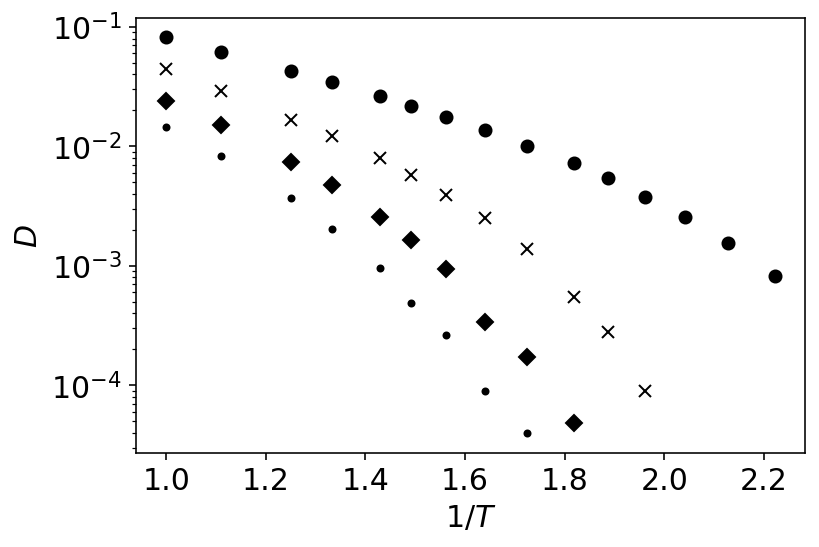

In [17]:
# plot_D_vs_invT(time, msds)
plot_D_vs_invT_cutoffs(time, msds, [None, 3, 5, 6], slc=slice(20,40))

In [29]:
def add_inner_plot_text(ax, text, x=.88, y=.9):
    ylog = ax.get_yscale() == "log"
    xlog = ax.get_xscale() == "log"
    (y0, y1) = ax.get_ylim()
    (x0, x1) = ax.get_xlim()
    if xlog:
        x = np.exp(np.log(x0) - x*(np.log(x0) - np.log(x1)))
    else:
        x = x0 - x*(x0 - x1)
    if ylog:
        y = np.exp(np.log(y0) - y*(np.log(y0) - np.log(y1)))
    else:
        y = y0 - y*(y0 - y1)
    ax.text(x, y, text)

In [51]:
set_c = lambda x: cm.Set1(x)
colorz = [set_c(x) for x in [0.0, 0.12, 0.25, 0.37]]

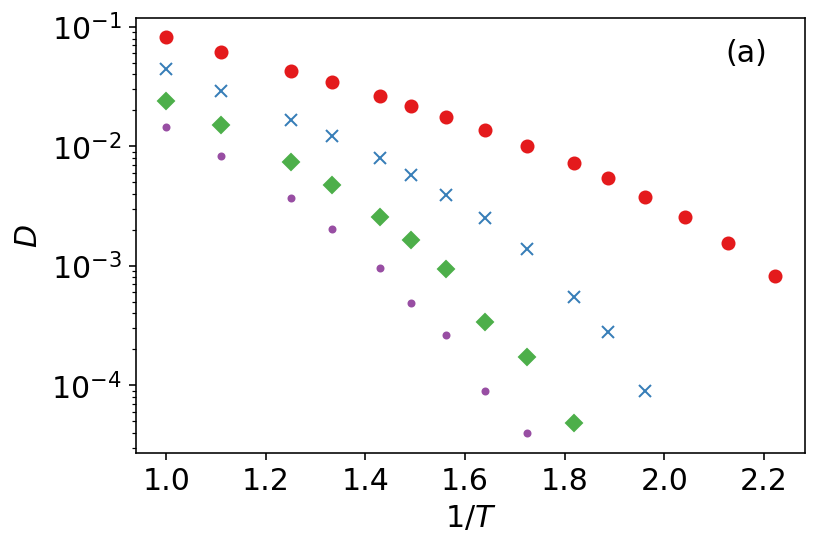

In [52]:
# plot_D_vs_invT(time, msds)
plot_D_vs_invT_cutoffs(time, msds, [None, 3, 5, 6], slc=slice(20,40), colorz=colorz)
add_inner_plot_text(plt.gca(), "(a)")

In [54]:
colorz = [(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0)]